# Age Prediction

Predicting the general age of a person based on their facial characteristics is a well-known, and still unsolved problem in machine learning. Predicting the age of a person can be useful for applications such as entertainment (providing age appropriate content), biometrics, or even just for providing a more customized user experience based on a target age.

In [15]:
!pip install -q tensorflow
!pip install -q seaborn

In [16]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

current_directory = os.getcwd()

%matplotlib inline

## Data preparation, data cleaning, and EDA

Follow instructions in ./face-age-detection/README.md to download and unzip the dataset

In [17]:
# Read the CSV file
labels_df = pd.read_csv(current_directory + '/face-age-detection/train.csv')
labels_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


,ID,Class
count,19906,19906
unique,19906,3
top,9896.jpg,MIDDLE
freq,1,10804


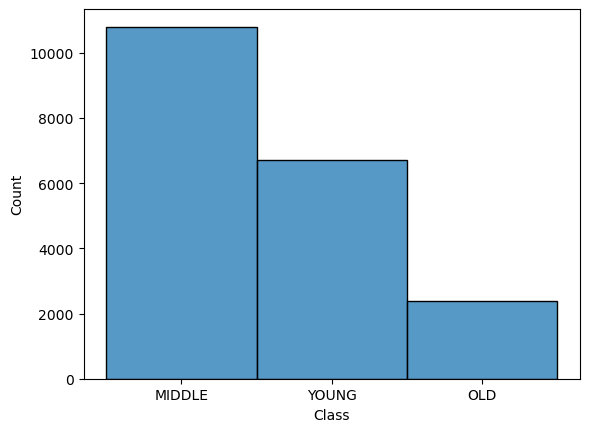

In [18]:
sns.histplot(labels_df['Class'])

print(labels_df['Class'].value_counts())

labels_df.describe()

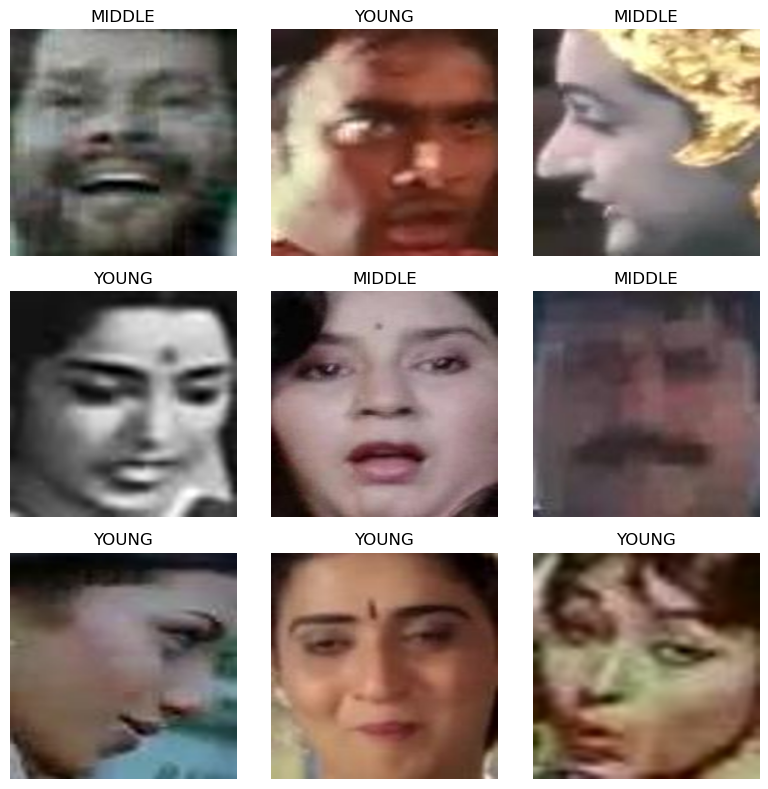

In [19]:
from tensorflow.keras.preprocessing.image import load_img
train_dir = current_directory + '/face-age-detection/Train/'

#generate a plot of 9 images (3x3 grid) with the image name and the class name below each image
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    axes = axes.flatten()
    for img, ax, label in zip( images_arr, axes, labels_arr):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get the first 9 images from the train dataset
imgs = []
labels = []
for i in range(9):
    row = labels_df.iloc[i]
    img = load_img(train_dir + row['ID'])
    #use pillow to resize the image to 150x150
    img = img.resize((299,299))
    
    imgs.append(img)
    labels.append(row['Class'])

# Plot the first 9 images
plotImages(imgs, labels)
    


## Model selection process and parameter tuning


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


SEED = 42

df_train, df_test = train_test_split(labels_df, test_size=0.4, random_state=SEED)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=SEED)

df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)


In [21]:

# train_datagen = ImageDataGenerator(
#     # rescale=1/255
# )
train_datagen = ImageDataGenerator(
    # rescale=1/255,
    
    # rotation_range=50,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest'
)
target_size = (150,150)

batch_size = 32

generator_args = dict(
    directory=train_dir,
    x_col='ID',
    y_col='Class',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=target_size
)
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    **generator_args
)

# Validation data generator
val_datagen = ImageDataGenerator(
    # rescale=1/255
)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    **generator_args
)

Found 11943 validated image filenames belonging to 3 classes.
Found 3982 validated image filenames belonging to 3 classes.


In [22]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)


In [ ]:
def make_simple_model(learning_rate=0.1, size_inner=64,droprate=0.5,  shape = (150,150,3)):

    inputs = keras.Input(shape=shape)

    feature_map = keras.layers.Conv2D(32,(3,3), activation='relu')(inputs)

    vectors = keras.layers.MaxPooling2D(pool_size=(2,2))(feature_map)
    flattened = keras.layers.Flatten()(vectors)

    dense_layer = keras.layers.Dense(size_inner, activation='relu')(flattened)
    drop = keras.layers.Dropout(droprate)(dense_layer)

    outputs = keras.layers.Dense(3, activation='softmax')(drop)
    simple_model = keras.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate
    )
    loss = keras.losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction="sum_over_batch_size",
        name="categorical_crossentropy",
    )
    simple_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return simple_model


In [ ]:
learning_rate = 0.01
size_inner=10
droprate=0.5
scores = {}


for learning_rate in [0.01,0.1,0.001]:
    print(size)
    checkpoint = keras.callbacks.ModelCheckpoint(
        'inception_'+str(learning_rate)+'__{epoch:02d}_{val_accuracy:.3f}.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
    model = make_simple_model(learning_rate=learning_rate, size_inner=size_inner,droprate=droprate)
    history = model.fit(train_generator, epochs=5, validation_data=val_generator,callbacks=[checkpoint])
    scores[size] = history.history

    print()
    print()

100
Epoch 1/5
374/374 [==============================] - ETA: 0s - loss: 223.8624 - accuracy: 0.5454

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


374/374 [==============================] - 90s 239ms/step - loss: 223.8624 - accuracy: 0.5454 - val_loss: 0.9771 - val_accuracy: 0.5404
Epoch 2/5
374/374 [==============================] - 90s 240ms/step - loss: 0.9938 - accuracy: 0.5532 - val_loss: 0.9773 - val_accuracy: 0.5291
Epoch 3/5
326/374 [=========================>....] - ETA: 10s - loss: 0.9537 - accuracy: 0.5484

In [ ]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.50, 0.60, 0.70])
plt.legend()

In [ ]:
# plt.plot(simple_model_history.history['accuracy'], label=('train'))
# plt.plot(simple_model_history.history['val_accuracy'], label=('val'))

# plt.xticks(np.arange(10))
# plt.legend()

In [ ]:
# train_datagen = ImageDataGenerator(
#     rescale=1/255,
    
#     rotation_range=50,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# # Training data generator
# train_generator = train_datagen.flow_from_dataframe(
#     df_train,
#     **generator_args
# )

# aug_model_history = simple_model.fit(train_generator,
#     epochs=10,
#     validation_data=val_generator,
#     callbacks=[checkpoint]
# )

In [ ]:
# plt.plot(aug_model_history.history['accuracy'], label=('train'))
# plt.plot(aug_model_history.history['val_accuracy'], label=('val'))

# plt.xticks(np.arange(10))
# plt.legend()

In [ ]:
# test_generator = val_datagen.flow_from_dataframe(
#     df_test,
#     directory=train_dir,
#     x_col='ID',
#     y_col='Class',
#     class_mode='categorical',
#     batch_size=batch_size,
#     target_size=target_size
# )
# simple_model.evaluate(test_generator)

Try transfer learning using the InceptionResNetV2 model 

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess
def make_inception_model(learning_rate=0.1, size_inner=100,droprate=0.5,  shape = (150,150,3)):
    inception = InceptionResNetV2(include_top=False, weights='imagenet')

    inception.trainable = False

    inputs = keras.Input(shape=shape)

    x = preprocess(inputs)
    x = inception(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    # drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(3, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate
    )
    loss = keras.losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction="sum_over_batch_size",
        name="categorical_crossentropy",
    )
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

model = make_inception_model()
model.summary()

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'inception_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
model_history = model.fit(train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

In [ ]:
# plt.plot(model_history.history['accuracy'], label=('train'))
# plt.plot(model_history.history['val_accuracy'], label=('val'))

# plt.xticks(np.arange(10))
# plt.legend()

In [ ]:
from io import BytesIO
import requests
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array

url = 'https://www.tzvi.dev/images/headshot_steve_friedman_circle_clear.png'

result = requests.get(url)
test_image = load_img(BytesIO(result.content),target_size=(150,150))
test_image

In [ ]:
image = img_to_array(test_image)
image = np.expand_dims(image, axis=0)
predictions = model.predict(image)
# create a function to decode the predictions
# def decode_predictions(predictions, class_names):
#     results = []
#     for prediction in predictions:
#         result = {class_names[i]: float(prediction[i]) for i in range(len(prediction))}
#         results.append(result)
#     return results


# decode_predictions(predictions, class_names)[0]

dict(zip(train_generator.class_indices.keys(), predictions[0]))
# predictions